# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn.functional as F 

from tqdm.notebook import tqdm
import utils

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load MNIST Handwritten Dataset

In [3]:
from torchvision import datasets 
from torchvision import transforms as T

In [4]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.ToTensor(), # (h, w, c) -> (c, h, w)
    T.Normalize(mean = 0.5, std = 0.5)
])

valid_augs = T.Compose([
    T.ToTensor(),
    T.Normalize(mean = 0.5, std = 0.5)
])

In [5]:
trainset = datasets.MNIST('./', download = False, train = True, transform = train_augs)
testset = datasets.MNIST('./', download = False, train = False, transform = valid_augs)

In [6]:
trainset, validset = torch.utils.data.random_split(trainset, [50000, 10000])

In [7]:
print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")
print(f"Size of testset : {len(testset)}")

Size of trainset : 50000
Size of validset : 10000
Size of testset : 10000


shape of image : torch.Size([1, 28, 28])
For visualization we need (h x w x c) so using permute shape will be : torch.Size([28, 28, 1])


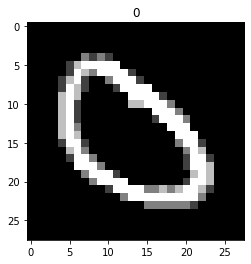

In [8]:
idx = 1
image, label = trainset[idx]

print(f'shape of image : {image.shape}')

print(f'For visualization we need (h x w x c) so using permute shape will be : {image.permute(1, 2, 0).shape}')

plt.imshow(image.permute(1, 2, 0), cmap = 'gray')
plt.title(label);

# Load Dataset into batches

In [9]:
from torch.utils.data import DataLoader

In [10]:
bs = 64

trainloader = DataLoader(trainset, batch_size = bs, shuffle = True)
validloader = DataLoader(validset, batch_size = bs)
testloader = DataLoader(testset, batch_size = bs)

In [11]:
print(f'Total no. of batches in trainloader : {len(trainloader)}')
print(f'Total no. of batches in validloader : {len(validloader)}')
print(f'Total no. of batches in testloader : {len(testloader)}')

Total no. of batches in trainloader : 782
Total no. of batches in validloader : 157
Total no. of batches in testloader : 157


In [12]:
for images, labels in trainloader:
    print(f"One images batch shape : {images.shape}")
    print(f"One labels batch shape : {labels.shape}")
    break

One images batch shape : torch.Size([64, 1, 28, 28])
One labels batch shape : torch.Size([64])


# Load Model 

In [13]:
from models import DigitModel

model = DigitModel()
model.to(device)

DigitModel(
  (cnn_block): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_featu

# Create Train and Eval Function

In [14]:
def train_fn(model, dataloader, criterion, optimizer):
    
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    
    for images, labels in tqdm(dataloader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += utils.multiclass_accuracy(logits, labels)
        
    return total_loss / len(dataloader), total_acc / len(dataloader)

In [15]:
def eval_fn(model, dataloader, criterion):
    
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    
    with torch.no_grad():

        for images, labels in tqdm(dataloader):

            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            total_acc += utils.multiclass_accuracy(logits, labels)

        return total_loss / len(dataloader), total_acc / len(dataloader)

# Training Loop 

In [16]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003)

In [ ]:
best_valid_loss = np.Inf

for i in range(20):
    
    train_loss, train_acc = train_fn(model, trainloader, criterion, optimizer)
    valid_loss, valid_acc = eval_fn(model, trainloader, criterion)
    
    print(f"Epoch {i+1} Train Loss : {train_loss} Train Acc : {train_acc}")
    print(f"Epoch {i+1} Valid Loss : {valid_loss} Valid Acc : {valid_acc}")
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_weights.pt')
        print("SAVED-BEST-MODEL")
        best_valid_loss = valid_loss

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1 Train Loss : 0.7865496235697166 Train Acc : 0.7246842980384827
Epoch 1 Valid Loss : 0.26872970245759503 Valid Acc : 0.9183583855628967
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2 Train Loss : 0.38511289881013544 Train Acc : 0.8795356750488281
Epoch 2 Valid Loss : 0.17375542739849262 Valid Acc : 0.9475902915000916
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3 Train Loss : 0.30566870023870407 Train Acc : 0.9078084826469421
Epoch 3 Valid Loss : 0.14977031280917813 Valid Acc : 0.9568614363670349
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4 Train Loss : 0.2679450592202375 Train Acc : 0.9199368357658386
Epoch 4 Valid Loss : 0.13684743458924392 Valid Acc : 0.9618965983390808
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5 Train Loss : 0.2442643467665595 Train Acc : 0.9270100593566895
Epoch 5 Valid Loss : 0.12088762120107936 Valid Acc : 0.9633751511573792
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6 Train Loss : 0.2265410356514175 Train Acc : 0.9321651458740234
Epoch 6 Valid Loss : 0.10876779373177825 Valid Acc : 0.9680706262588501
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7 Train Loss : 0.21948593562168767 Train Acc : 0.9351022839546204
Epoch 7 Valid Loss : 0.11293907581930956 Valid Acc : 0.9670916199684143


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8 Train Loss : 0.21039993576038524 Train Acc : 0.9387388229370117
Epoch 8 Valid Loss : 0.11034778801157423 Valid Acc : 0.968410313129425


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9 Train Loss : 0.19728805397368035 Train Acc : 0.942255437374115
Epoch 9 Valid Loss : 0.1181478119571991 Valid Acc : 0.9641544222831726


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10 Train Loss : 0.19215666993385386 Train Acc : 0.9422155022621155
Epoch 10 Valid Loss : 0.0940359157481519 Valid Acc : 0.9716671705245972
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 11 Train Loss : 0.18773937813313607 Train Acc : 0.9458519816398621
Epoch 11 Valid Loss : 0.09018875315756825 Valid Acc : 0.9730658531188965
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 12 Train Loss : 0.17678225193353717 Train Acc : 0.9492686986923218
Epoch 12 Valid Loss : 0.10085712765436382 Valid Acc : 0.9700887203216553


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 13 Train Loss : 0.18027596983372632 Train Acc : 0.9476103186607361
Epoch 13 Valid Loss : 0.08723320012859752 Valid Acc : 0.974044919013977
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 14 Train Loss : 0.1726527261438177 Train Acc : 0.9493286609649658
Epoch 14 Valid Loss : 0.08971406211076147 Valid Acc : 0.9730658531188965


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 15 Train Loss : 0.16828700619251907 Train Acc : 0.9508671760559082
Epoch 15 Valid Loss : 0.09338726342329398 Valid Acc : 0.9733655452728271


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 16 Train Loss : 0.1671776067313102 Train Acc : 0.9517063498497009
Epoch 16 Valid Loss : 0.08821761898953667 Valid Acc : 0.9720068573951721


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 17 Train Loss : 0.15824671235868035 Train Acc : 0.954883337020874
Epoch 17 Valid Loss : 0.09048960167471595 Valid Acc : 0.9735853672027588


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 18 Train Loss : 0.1633880632998579 Train Acc : 0.9527653455734253
Epoch 18 Valid Loss : 0.08415776664388779 Valid Acc : 0.9729260206222534
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 19 Train Loss : 0.1533395899781276 Train Acc : 0.9564817547798157
Epoch 19 Valid Loss : 0.08029878002536647 Valid Acc : 0.9768022894859314
SAVED-BEST-MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

# Inference

In [ ]:
image, label = testset[0]

weights = torch.load('best_weights.pt')
model.load_state_dict(weights)

model.eval()
with torch.no_grad():
    logits = model(image.unsqueeze(0)) # (c, h, w) -> (1, c, h, w)
    ps = torch.nn.Softmax(dim = 1)(logits)[0]
    utils.view_classify(image, ps)